# Dar Koridor Analizi 2: Devlet ve Toplum Gücü (1996-2023)

In [25]:
# Kütüphaneleri yükle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.rotator import Rotator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import json
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Rastgele tohum
np.random.seed(42)

print("✓ Kütüphaneler yüklendi")


✓ Kütüphaneler yüklendi


## 1. Ülke Adı Eşleme Sözlüğü

WGI ve V-Dem veri setlerinde aynı ülkeler farklı isimlerle yazılmış. Bu eşlemeleri yapılandırıyoruz.


In [26]:
# Ülke adı eşleme sözlükleri
# WGI'den güncel ada
wgi_to_standard = {
    'Myanmar': 'Myanmar',
    'Czech Republic': 'Czechia',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Congo, Rep.': 'Republic of the Congo',
    'Egypt, Arab Rep.': 'Egypt',
    'Hong Kong SAR, China': 'Hong Kong SAR (China)',
    'Iran, Islamic Rep.': 'Iran',
    'Côte d\'Ivoire': 'Côte d\'Ivoire',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Lao PDR': 'Lao PDR',
    'Korea, Dem. Rep.': 'Democratic People\'s Republic of Korea',
    'Korea, Rep.': 'Republic of Korea',
    'São Tomé and Principe': 'São Tomé and Príncipe',
    'Slovak Republic': 'Slovakia',
    'Syrian Arab Republic': 'Syrian Arab Republic',
    'Taiwan, China': 'Taiwan',
    'Gambia, The': 'The Gambia',
    'United States': 'United States of America',
    'Venezuela, RB': 'Bolivarian Republic of Venezuela',
    'Viet Nam': 'Viet Nam',
    'Yemen, Rep.': 'Republic of Yemen'
}

# V-Dem'den güncel ada (sadece 1996+ için uygulanacak)
vdem_to_standard = {
    'Burma/Myanmar': 'Myanmar',
    'Czechia': 'Czechia',
    'Democratic Republic of the Congo': 'Democratic Republic of the Congo',
    'Republic of the Congo': 'Republic of the Congo',
    'Egypt': 'Egypt',
    'Hong Kong': 'Hong Kong SAR (China)',
    'Iran': 'Iran',
    'Ivory Coast': 'Côte d\'Ivoire',
    'Kyrgyzstan': 'Kyrgyzstan',
    'Laos': 'Lao PDR',
    'North Korea': 'Democratic People\'s Republic of Korea',
    'South Korea': 'Republic of Korea',
    'Sao Tome and Principe': 'São Tomé and Príncipe',
    'Slovakia': 'Slovakia',
    'Syria': 'Syrian Arab Republic',
    'Taiwan': 'Taiwan',
    'The Gambia': 'The Gambia',
    'United States of America': 'United States of America',
    'Venezuela': 'Bolivarian Republic of Venezuela',
    'Vietnam': 'Viet Nam',
    'Yemen': 'Republic of Yemen'
}

def normalize_country_names_wgi(df, column='countryname'):
    """WGI ülke adlarını standart hale getir"""
    df = df.copy()
    df[column] = df[column].replace(wgi_to_standard)
    return df

def normalize_country_names_vdem(df, column='country_name', year_column='year'):
    """V-Dem ülke adlarını standart hale getir (sadece 1996+)"""
    df = df.copy()
    # Sadece 1996 ve sonrası için dönüşüm yap
    mask_1996_plus = df[year_column] >= 1996
    df.loc[mask_1996_plus, column] = df.loc[mask_1996_plus, column].replace(vdem_to_standard)
    return df

print(f"✓ {len(wgi_to_standard)} WGI eşlemesi")
print(f"✓ {len(vdem_to_standard)} V-Dem eşlemesi")


✓ 21 WGI eşlemesi
✓ 21 V-Dem eşlemesi


## 2. Veri Yükleme

WGI ve V-Dem veri setlerini yüklüyoruz. Sadece gerekli sütunları alarak belleği koruyoruz.


In [27]:
# WGI verisi yükle
print("WGI verisi yükleniyor...")
wgi = pd.read_csv('../Datasets/wgidataset.csv', 
                  sep=';',
                  usecols=['countryname', 'year', 'indicator', 'estimate'])

# estimate sütunundaki virgülü noktaya çevir
wgi['estimate'] = wgi['estimate'].astype(str).str.replace(',', '.').replace('..', np.nan)
wgi['estimate'] = pd.to_numeric(wgi['estimate'], errors='coerce')

# 1996 ve sonrasını filtrele
wgi = wgi[wgi['year'] >= 1996].copy()

# Ülke adlarını normalize et
wgi = normalize_country_names_wgi(wgi)

print(f"✓ WGI: {len(wgi)} satır, {wgi['year'].min()}-{wgi['year'].max()}")
print(f"  Göstergeler: {wgi['indicator'].unique()}")
print(f"  Ülke sayısı: {wgi['countryname'].nunique()}")

# WGI veri setinin ilk birkaç satırını göster
display(wgi.head())


WGI verisi yükleniyor...
✓ WGI: 32100 satır, 1996-2023
  Göstergeler: ['cc' 'ge' 'pv' 'rl' 'rq' 'va']
  Ülke sayısı: 214


,countryname,year,indicator,estimate
0,Afghanistan,1996,cc,-1.29
1,Albania,1996,cc,-0.89
2,Algeria,1996,cc,-0.57
3,American Samoa,1996,cc,NaN
4,Andorra,1996,cc,1.32


In [28]:
# V-Dem verisi yükle (sadece gerekli sütunlar)
print("\nV-Dem verisi yükleniyor (bu biraz zaman alabilir)...")
vdem_cols = ['country_name', 'year', 'v2x_jucon', 'v2xlg_legcon', 'v2xcs_ccsi', 
             'v2x_cspart', 'v2xel_frefair', 'v2x_freexp_altinf', 'v2psoppaut', 'v2csreprss']
vdem = pd.read_csv('../Datasets/V-Dem-CY-Full+Others-v15.csv', 
                   usecols=vdem_cols,
                   low_memory=False)

# 1996 ve sonrasını filtrele
vdem = vdem[vdem['year'] >= 1996].copy()

# Ülke adlarını normalize et (sadece 1996+)
vdem = normalize_country_names_vdem(vdem)

# Eksik değerleri kaldır
vdem = vdem.dropna(subset=['v2x_jucon', 'v2xlg_legcon', 'v2xcs_ccsi', 
                            'v2x_cspart', 'v2xel_frefair', 'v2x_freexp_altinf', 
                            'v2psoppaut', 'v2csreprss'])

print(f"✓ V-Dem: {len(vdem)} satır, {vdem['year'].min()}-{vdem['year'].max()}")
print(f"  Ülke sayısı: {vdem['country_name'].nunique()}")
print(f"  Değişkenler: v2x_jucon, v2xlg_legcon, v2xcs_ccsi, v2x_cspart, v2xel_frefair, v2x_freexp_altinf, v2psoppaut, v2csreprss")

# V-Dem veri setinin ilk birkaç satırını göster
display(vdem.head())



V-Dem verisi yükleniyor (bu biraz zaman alabilir)...
✓ V-Dem: 4970 satır, 1996-2024
  Ülke sayısı: 178
  Değişkenler: v2x_jucon, v2xlg_legcon, v2xcs_ccsi, v2x_cspart, v2xel_frefair, v2x_freexp_altinf, v2psoppaut, v2csreprss


,country_name,year,v2x_freexp_altinf,v2xel_frefair,v2x_jucon,v2xlg_legcon,v2x_cspart,v2psoppaut,v2csreprss,v2xcs_ccsi
207,Mexico,1996,0.687,0.626,0.577,0.284,0.521,1.484,-0.416,0.473
208,Mexico,1997,0.687,0.728,0.577,0.512,0.574,1.484,-0.290,0.520
209,Mexico,1998,0.687,0.794,0.577,0.542,0.574,1.484,1.008,0.619
210,Mexico,1999,0.687,0.794,0.577,0.542,0.611,1.484,1.008,0.671
211,Mexico,2000,0.775,0.814,0.731,0.760,0.712,1.600,1.697,0.767


## 3. Veri Hazırlığı ve Birleştirme

WGI'yi wide formata çevirip V-Dem ile birleştiriyoruz. Sadece ortak ülke-yıl kombinasyonları kalacak.


In [29]:
# WGI'yi wide formata çevir
print("WGI wide formata çeviriliyor...")
wgi_wide = wgi.pivot_table(
    index=['countryname', 'year'],
    columns='indicator',
    values='estimate'
).reset_index()

# Sütun adlarını büyük harfe çevir
wgi_wide.columns.name = None
indicator_cols = ['pv', 'ge', 'rq', 'rl', 'cc']
rename_dict = {col: col.upper() for col in indicator_cols if col in wgi_wide.columns}
wgi_wide = wgi_wide.rename(columns=rename_dict)

# pv -> PS (Political Stability)
if 'PV' in wgi_wide.columns:
    wgi_wide = wgi_wide.rename(columns={'PV': 'PS'})

print(f"✓ WGI wide: {wgi_wide.shape}")
print(f"  Sütunlar: {[c for c in wgi_wide.columns if c not in ['countryname', 'year']]}")


WGI wide formata çeviriliyor...
✓ WGI wide: (5246, 8)
  Sütunlar: ['CC', 'GE', 'PS', 'RL', 'RQ', 'va']


In [30]:
# WGI ve V-Dem'i birleştir (inner join - sadece ortak ülke-yıl)
print("\nWGI ve V-Dem birleştiriliyor...")
merged = pd.merge(
    wgi_wide,
    vdem,
    left_on=['countryname', 'year'],
    right_on=['country_name', 'year'],
    how='inner'
)

# country_name sütununu kaldır (countryname ile aynı)
merged = merged.drop(columns=['country_name'])

# Eksik değerleri temizle
n_before = len(merged)
merged = merged.dropna(subset=['PS', 'GE', 'RQ', 'RL', 'CC', 
                                'v2x_jucon', 'v2xlg_legcon', 'v2xcs_ccsi', 
                                'v2x_cspart', 'v2xel_frefair', 'v2x_freexp_altinf', 
                                'v2psoppaut', 'v2csreprss'])
n_after = len(merged)

print(f"✓ Birleştirilmiş veri: {merged.shape}")
print(f"  Ülke sayısı: {merged['countryname'].nunique()}")
print(f"  Yıl aralığı: {merged['year'].min()}-{merged['year'].max()}")
print(f"  Eksik değer temizliği: {n_before} -> {n_after} satır ({n_before-n_after} satır silindi)")
print(f"\n✓ İlk 5 ülke (örnek):")
print(merged[['countryname', 'year']].groupby('countryname').count().head())

# Tüm satır ve sütunların kısaltılmadan görüntülenmesi için ayar
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Yeni veri setinin tüm satırlarını ve sütunlarını göster
display(merged.head(30))



WGI ve V-Dem birleştiriliyor...
✓ Birleştirilmiş veri: (4160, 16)
  Ülke sayısı: 173
  Yıl aralığı: 1996-2023
  Eksik değer temizliği: 4185 -> 4160 satır (25 satır silindi)

✓ İlk 5 ülke (örnek):
             year
countryname      
Afghanistan    19
Albania        25
Algeria        25
Angola         25
Argentina      25


,countryname,year,CC,GE,PS,RL,RQ,va,v2x_freexp_altinf,v2xel_frefair,v2x_jucon,v2xlg_legcon,v2x_cspart,v2psoppaut,v2csreprss,v2xcs_ccsi
0,Afghanistan,2005,-1.45,-1.23,-2.07,-1.66,-1.64,-1.13,0.684,0.241,0.233,0.483,0.665,0.631,1.658,0.725
1,Afghanistan,2006,-1.45,-1.47,-2.22,-1.88,-1.69,-1.11,0.687,0.241,0.244,0.571,0.678,0.631,1.658,0.728
2,Afghanistan,2007,-1.61,-1.44,-2.41,-1.85,-1.71,-1.06,0.685,0.241,0.244,0.592,0.655,0.631,1.658,0.721
3,Afghanistan,2008,-1.67,-1.53,-2.69,-1.90,-1.61,-1.17,0.716,0.241,0.244,0.602,0.655,0.631,1.627,0.710
4,Afghanistan,2009,-1.55,-1.51,-2.71,-1.88,-1.66,-1.38,0.718,0.215,0.248,0.610,0.672,0.631,1.627,0.714
5,Afghanistan,2010,-1.65,-1.48,-2.58,-1.87,-1.52,-1.40,0.723,0.175,0.248,0.628,0.671,0.631,1.627,0.701
6,Afghanistan,2011,-1.60,-1.47,-2.50,-1.92,-1.54,-1.34,0.723,0.186,0.248,0.628,0.671,0.631,1.583,0.703
7,Afghanistan,2012,-1.43,-1.38,-2.42,-1.65,-1.19,-1.27,0.722,0.195,0.248,0.628,0.671,0.631,1.583,0.703
8,Afghanistan,2013,-1.45,-1.40,-2.52,-1.61,-1.19,-1.24,0.712,0.193,0.234,0.682,0.676,0.473,1.180,0.693
9,Afghanistan,2014,-1.36,-1.36,-2.41,-1.44,-1.12,-1.14,0.697,0.195,0.225,0.710,0.635,0.473,1.165,0.674


In [31]:
# Birleştirme sonrası eksik değerlere sahip satırları bul
merged_before_drop = pd.merge(
    wgi_wide,
    vdem,
    left_on=['countryname', 'year'],
    right_on=['country_name', 'year'],
    how='inner'
).drop(columns=['country_name'])

# Eksik değere sahip satırları filtrele
missing_rows = merged_before_drop[
    merged_before_drop[['PS', 'GE', 'RQ', 'RL', 'CC', 
                        'v2x_jucon', 'v2xlg_legcon', 'v2xcs_ccsi', 
                        'v2x_cspart', 'v2xel_frefair', 'v2x_freexp_altinf', 
                        'v2psoppaut', 'v2csreprss']].isna().any(axis=1)
]

print(f"Silinen {len(missing_rows)} satır:")
print(missing_rows[['countryname', 'year', 'PS', 'GE', 'RQ', 'RL', 'CC', 
                    'v2x_jucon', 'v2xlg_legcon', 'v2xcs_ccsi', 
                    'v2x_cspart', 'v2xel_frefair', 'v2x_freexp_altinf', 
                    'v2psoppaut', 'v2csreprss']])

# Her göstergede kaç eksik var?
print("\nHer göstergede eksik değer sayısı:")
for col in ['PS', 'GE', 'RQ', 'RL', 'CC', 
            'v2x_jucon', 'v2xlg_legcon', 'v2xcs_ccsi', 
            'v2x_cspart', 'v2xel_frefair', 'v2x_freexp_altinf', 
            'v2psoppaut', 'v2csreprss']:
    n_missing = missing_rows[col].isna().sum()
    print(f"  {col}: {n_missing} eksik")

Silinen 25 satır:
          countryname  year    PS    GE    RQ    RL    CC  v2x_jucon  \
666        Cape Verde  1996  1.04   NaN -0.53  1.04  1.14      0.921   
667        Cape Verde  1998  1.11   NaN -0.45  0.67  1.16      0.921   
668        Cape Verde  2000  1.22   NaN -0.02  0.64  1.13      0.921   
2030           Kosovo  2000   NaN   NaN   NaN -0.02  0.37      0.780   
2031           Kosovo  2002   NaN   NaN   NaN -0.06  0.36      0.788   
2032           Kosovo  2003   NaN   NaN   NaN -0.83 -0.50      0.788   
2033           Kosovo  2004   NaN   NaN   NaN -0.80 -0.31      0.788   
2034           Kosovo  2005   NaN   NaN   NaN -0.82 -0.53      0.772   
2035           Kosovo  2006   NaN -0.34   NaN -0.86 -0.51      0.772   
2036           Kosovo  2007   NaN -0.22  0.04 -0.76 -0.74      0.772   
2572       Montenegro  2000   NaN   NaN   NaN  0.32 -0.18      0.737   
2573       Montenegro  2002   NaN   NaN   NaN  0.27 -0.16      0.737   
2574       Montenegro  2003   NaN   NaN   NaN 

In [32]:
# Yeni veri setinde kaç ülke var? Hangileri?
country_list = merged['countryname'].unique()
print(f"Yeni veri setinde {len(country_list)} ülke var.")

# Ülkeleri tablo halinde göster
import pandas as pd
country_table = pd.DataFrame({'Ülke': sorted(country_list)})
display(country_table)


Yeni veri setinde 173 ülke var.


,Ülke
0,Afghanistan
1,Albania
2,Algeria
3,Angola
4,Argentina
5,Armenia
6,Australia
7,Austria
8,Azerbaijan
9,Bahrain


## 4. Standartlaştırma (Yıllık Z-Skorlama)

Her yıl içinde göstergeleri z-skoruna çeviriyoruz. Bu, farklı yılların değerlerinin karşılaştırılabilir olmasını sağlar.


In [33]:
# 13 göstergeyi standardize et (yıl bazında)
indicators = ['RL', 'GE', 'CC', 'RQ', 'PS', 
              'v2x_jucon', 'v2xlg_legcon', 'v2xcs_ccsi', 
              'v2x_cspart', 'v2xel_frefair', 'v2x_freexp_altinf', 
              'v2psoppaut', 'v2csreprss']

print("Yıllık z-skorlama uygulanıyor...")
merged_std = merged.copy()

for indicator in indicators:
    # Her yıl için ayrı ayrı standardize et
    merged_std[f'{indicator}_std'] = merged_std.groupby('year')[indicator].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# Standartlaştırılmış sütunları listele
std_cols = [f'{ind}_std' for ind in indicators]

print(f"✓ {len(indicators)} gösterge standardize edildi")
print(f"  Orijinal: {indicators}")
print(f"  Standart: {std_cols[:3]}... (örnek)")
print(f"\n✓ Standartlaştırılmış veri özeti:")
print(merged_std[std_cols].describe().round(2))


Yıllık z-skorlama uygulanıyor...
✓ 13 gösterge standardize edildi
  Orijinal: ['RL', 'GE', 'CC', 'RQ', 'PS', 'v2x_jucon', 'v2xlg_legcon', 'v2xcs_ccsi', 'v2x_cspart', 'v2xel_frefair', 'v2x_freexp_altinf', 'v2psoppaut', 'v2csreprss']
  Standart: ['RL_std', 'GE_std', 'CC_std']... (örnek)

✓ Standartlaştırılmış veri özeti:
        RL_std   GE_std   CC_std   RQ_std   PS_std  v2x_jucon_std  \
count  4160.00  4160.00  4160.00  4160.00  4160.00        4160.00   
mean     -0.00    -0.00     0.00     0.00    -0.00           0.00   
std       1.00     1.00     1.00     1.00     1.00           1.00   
min      -2.39    -2.30    -1.81    -2.45    -3.21          -1.92   
25%      -0.73    -0.72    -0.73    -0.70    -0.61          -0.96   
50%      -0.20    -0.17    -0.26    -0.15     0.08           0.27   
75%       0.66     0.66     0.56     0.73     0.78           0.87   
max       2.18     2.53     2.54     2.35     1.93           1.35   

       v2xlg_legcon_std  v2xcs_ccsi_std  v2x_cspart_std  

## 5. Faktör Analizi

İki gizil faktörü (devlet gücü ve toplum gücü) Varimax rotasyonlu faktör analizi ile çıkarıyoruz.


In [34]:
# Faktör analizi için veri hazırla
X = merged_std[std_cols].dropna()
valid_indices = X.index

print(f"Faktör analizi hazırlığı: {X.shape[0]} gözlem, {X.shape[1]} değişken")

# Faktör analizi modeli (2 faktör, varimax rotasyon)
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X)

# Faktör yüklerini göster
loadings = pd.DataFrame(
    fa.loadings_,
    index=indicators,
    columns=['Factor1', 'Factor2']
)

print("\n" + "="*60)
print("FAKTÖR YÜKLERİ (Varimax Rotasyon)")
print("="*60)
print(loadings.round(3))

# Her faktörün açıkladığı varyans
variance = fa.get_factor_variance()
variance_df = pd.DataFrame(
    variance,
    index=['SS Loadings', 'Proportional Var', 'Cumulative Var'],
    columns=['Factor1', 'Factor2']
)
print("\n" + "="*60)
print("AÇIKLANAN VARYANS")
print("="*60)
print(variance_df.round(3))


Faktör analizi hazırlığı: 4160 gözlem, 13 değişken

FAKTÖR YÜKLERİ (Varimax Rotasyon)
                   Factor1  Factor2
RL                   0.339    0.931
GE                   0.287    0.927
CC                   0.303    0.906
RQ                   0.413    0.841
PS                   0.232    0.734
v2x_jucon            0.744    0.530
v2xlg_legcon         0.762    0.392
v2xcs_ccsi           0.943    0.222
v2x_cspart           0.850    0.291
v2xel_frefair        0.668    0.614
v2x_freexp_altinf    0.935    0.255
v2psoppaut           0.809    0.346
v2csreprss           0.848    0.386

AÇIKLANAN VARYANS
                  Factor1  Factor2
SS Loadings         5.955    5.073
Proportional Var    0.458    0.390
Cumulative Var      0.458    0.848


In [35]:
# Faktör skorlarını hesapla
factor_scores = fa.transform(X)

# Ana veri setine ekle
merged_std.loc[valid_indices, 'Factor1'] = factor_scores[:, 0]
merged_std.loc[valid_indices, 'Factor2'] = factor_scores[:, 1]

# Faktör yüklerine göre isimlendirme
# Factor1: v2xcs_ccsi, v2x_freexp_altinf, v2x_cspart, vb. ağırlıklı -> TOPLUM GÜCÜ
# Factor2: RL, GE, CC, RQ, PS ağırlıklı -> DEVLET GÜCÜ

# Yorumlama için en yüksek yükleri kontrol et
print("\n" + "="*60)
print("FAKTÖR YORUMLAMA")
print("="*60)
for col in ['Factor1', 'Factor2']:
    top_vars = loadings[col].abs().sort_values(ascending=False).head(3)
    print(f"\n{col} - En yüksek yükler:")
    for var, load in top_vars.items():
        print(f"  {var:15s}: {load:6.3f}")

# Faktörleri isimlendirme
merged_std['StatePower'] = merged_std['Factor2']
merged_std['SocietyPower'] = merged_std['Factor1']

print("\n✓ Faktör skorları hesaplandı ve isimlendirildi:")
print(f"  - StatePower (Devlet Gücü)")
print(f"  - SocietyPower (Toplum Gücü)")
print(f"\n✓ Faktör skorları özeti:")
print(merged_std[['StatePower', 'SocietyPower']].describe().round(2))



FAKTÖR YORUMLAMA

Factor1 - En yüksek yükler:
  v2xcs_ccsi     :  0.943
  v2x_freexp_altinf:  0.935
  v2x_cspart     :  0.850

Factor2 - En yüksek yükler:
  RL             :  0.931
  GE             :  0.927
  CC             :  0.906

✓ Faktör skorları hesaplandı ve isimlendirildi:
  - StatePower (Devlet Gücü)
  - SocietyPower (Toplum Gücü)

✓ Faktör skorları özeti:
       StatePower  SocietyPower
count     4160.00       4160.00
mean        -0.00         -0.00
std          0.99          0.99
min         -2.50         -2.80
25%         -0.72         -0.52
50%         -0.20          0.43
75%          0.67          0.69
max          2.91          1.28


## 6. Kümeleme Analizi

K-means ile ülkeleri gruplandırıyoruz. Önce elbow grafiği ile optimal k değerini buluyoruz.


Kümeleme için hazırlık: 4160 gözlem


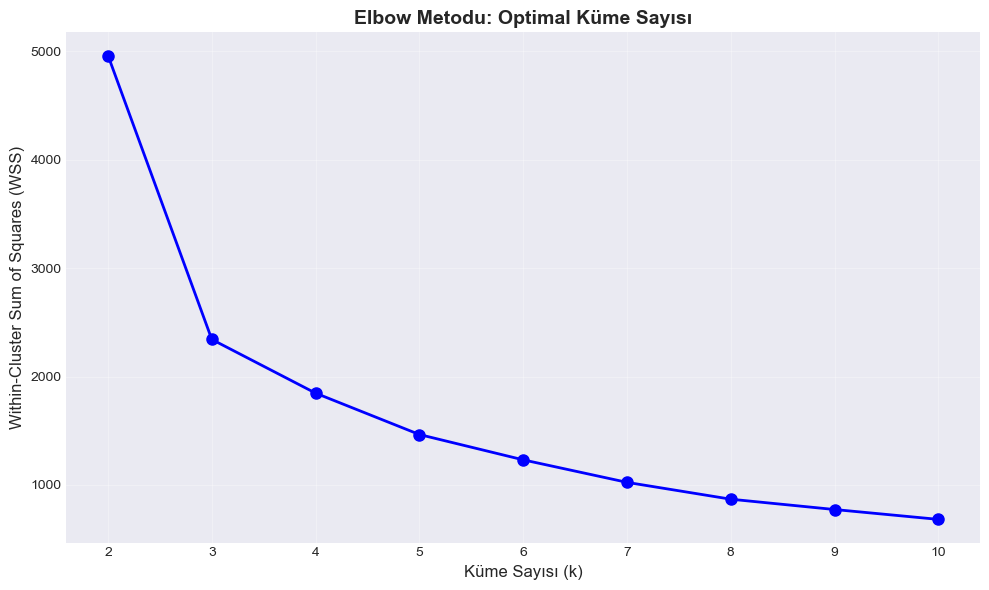

In [38]:
# Kümeleme için veri hazırla
cluster_data = merged_std[['StatePower', 'SocietyPower']].dropna()
cluster_indices = cluster_data.index

print(f"Kümeleme için hazırlık: {len(cluster_data)} gözlem")

# Elbow metodu - farklı k değerleri için WSS hesapla
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_data)
    inertias.append(kmeans.inertia_)

# Elbow grafiği
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax.set_ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=12)
ax.set_title('Elbow Metodu: Optimal Küme Sayısı', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()



In [ ]:
# Tüm gözlemlerin faktör skorlarına bakın
plt.scatter(cluster_data['StatePower'], cluster_data['SocietyPower'], alpha=0.3)

In [ ]:
# K=4 ile kümeleme yap
kmeans_3 = KMeans(n_clusters=4, random_state=42, n_init=20)
cluster_labels = kmeans_3.fit_predict(cluster_data)

# Ana veri setine ekle
merged_std.loc[cluster_indices, 'Cluster'] = cluster_labels

# Küme merkezlerini görüntüle
centers = pd.DataFrame(
    kmeans_3.cluster_centers_,
    columns=['StatePower', 'SocietyPower'],
    index=[f'Cluster {i}' for i in range(4)]
)

print("\n" + "="*60)
print("KÜME MERKEZLERİ (K=4)")
print("="*60)
print(centers.round(3))

# Her kümenin özelliklerini yorumla
print("\n" + "="*60)
print("KÜME YORUMLAMA")
print("="*60)
for i in range(4):
    sp = centers.loc[f'Cluster {i}', 'StatePower']
    sop = centers.loc[f'Cluster {i}', 'SocietyPower']
    count = (merged_std['Cluster'] == i).sum()
    
    # Leviathan tipini belirle
    if sp > 0.5 and sop > 0.5:
        lev_type = "Prangalanmış Leviathan (Shackled)"
    elif sp > 0.5 and sop < 0:
        lev_type = "Despotik Leviathan (Despotic)"
    elif sp < 0 and sop > 0:
        lev_type = "Mevcut Olmayan Leviathan (Absent)"
    elif sp < 0 and sop < 0:
        lev_type = "Kağıttan Leviathan (Paper)"
    else:
        lev_type = "Belirsiz"
    
    print(f"\nCluster {i}: {lev_type}")
    print(f"  StatePower:   {sp:6.3f}")
    print(f"  SocietyPower: {sop:6.3f}")
    print(f"  Gözlem sayısı: {count}")


KÜME MERKEZLERİ (K=4)
           StatePower  SocietyPower
Cluster 0      -0.488         0.708
Cluster 1       0.122        -1.821
Cluster 2       1.267         0.445
Cluster 3      -0.939        -0.273

KÜME YORUMLAMA

Cluster 0: Mevcut Olmayan Leviathan (Absent)
  StatePower:   -0.488
  SocietyPower:  0.708
  Gözlem sayısı: 1491

Cluster 1: Belirsiz
  StatePower:    0.122
  SocietyPower: -1.821
  Gözlem sayısı: 728

Cluster 2: Belirsiz
  StatePower:    1.267
  SocietyPower:  0.445
  Gözlem sayısı: 1116

Cluster 3: Kağıttan Leviathan (Paper)
  StatePower:   -0.939
  SocietyPower: -0.273
  Gözlem sayısı: 825


In [ ]:
# Cluster'ları Leviathan tiplerine göre yeniden etiketle
# Merkezlere göre manuel etiketleme
cluster_mapping = {}

for i in range(4):
    sp = centers.loc[f'Cluster {i}', 'StatePower']
    sop = centers.loc[f'Cluster {i}', 'SocietyPower']
    
    # Basit kuadrant mantığı
    if sp >= 0 and sop >= 0:
        cluster_mapping[i] = "Shackled"  # Yüksek devlet + Yüksek toplum
    elif sp >= 0 and sop < 0:
        cluster_mapping[i] = "Despotic"  # Yüksek devlet + Düşük toplum
    elif sp < 0 and sop >= 0:
        cluster_mapping[i] = "Absent"    # Düşük devlet + Yüksek toplum
    else:  # sp < 0 and sop < 0
        cluster_mapping[i] = "Paper"     # Düşük devlet + Düşük toplum

merged_std['LeviathanType'] = merged_std['Cluster'].map(cluster_mapping)

print("\n✓ Leviathan tipleri etiketlendi:")
print(merged_std['LeviathanType'].value_counts())
print(f"\n✓ Cluster -> Leviathan eşlemesi:")
for k, v in cluster_mapping.items():
    sp = centers.loc[f'Cluster {k}', 'StatePower']
    sop = centers.loc[f'Cluster {k}', 'SocietyPower']
    print(f"  Cluster {k} -> {v} (SP={sp:.2f}, SoP={sop:.2f})")



✓ Leviathan tipleri etiketlendi:
LeviathanType
Absent      1491
Shackled    1116
Paper        825
Despotic     728
Name: count, dtype: int64

✓ Cluster -> Leviathan eşlemesi:
  Cluster 0 -> Absent (SP=-0.49, SoP=0.71)
  Cluster 1 -> Despotic (SP=0.12, SoP=-1.82)
  Cluster 2 -> Shackled (SP=1.27, SoP=0.44)
  Cluster 3 -> Paper (SP=-0.94, SoP=-0.27)


## 7. Görselleştirme: 1996 ve 2022 Karşılaştırması

Dar Koridor grafiklerini oluşturuyoruz. 1996'da ülkelerin konumu ile 2022'deki konumlarını karşılaştırıyoruz.


1996: 158 ülke
2022: 166 ülke


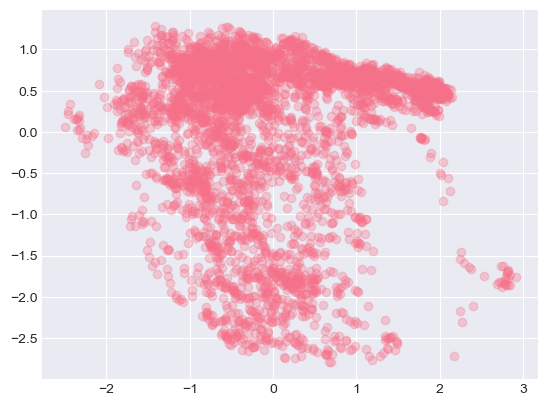

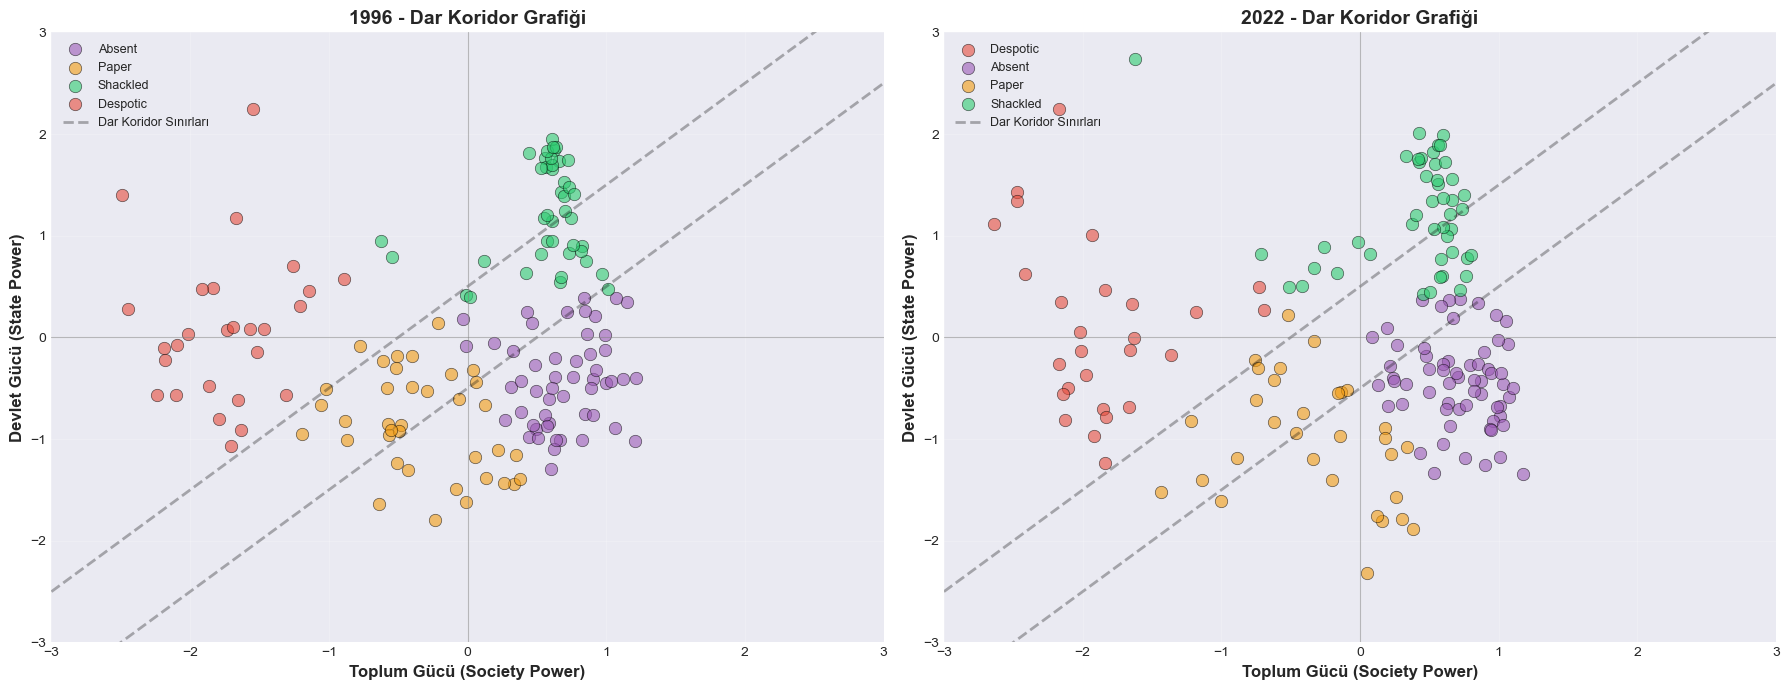


✓ 1996 ve 2022 Dar Koridor grafikleri oluşturuldu


In [ ]:
# 1996 ve 2022 verilerini hazırla
data_1996 = merged_std[merged_std['year'] == 1996].copy()
data_2022 = merged_std[merged_std['year'] == 2022].copy()

print(f"1996: {len(data_1996)} ülke")
print(f"2022: {len(data_2022)} ülke")

# Renk paleti
color_map = {
    'Shackled': '#2ecc71',  # Yeşil
    'Despotic': '#e74c3c',  # Kırmızı
    'Paper': '#f39c12',     # Turuncu
    'Absent': '#9b59b6'     # Mor
}

# 1996 grafiği
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for idx, (year, data) in enumerate([(1996, data_1996), (2022, data_2022)]):
    ax = axes[idx]
    
    # Her Leviathan tipi için ayrı scatter
    for lev_type in data['LeviathanType'].unique():
        if pd.isna(lev_type):
            continue
        subset = data[data['LeviathanType'] == lev_type]
        ax.scatter(subset['SocietyPower'], subset['StatePower'],
                  c=color_map.get(lev_type, 'gray'),
                  label=lev_type, alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
    
    # Dar Koridor çizgileri (yaklaşık)
    x_corr = np.linspace(-3, 3, 100)
    y_upper = x_corr + 0.5  # Üst sınır
    y_lower = x_corr - 0.5  # Alt sınır
    ax.plot(x_corr, y_upper, 'k--', alpha=0.3, linewidth=2, label='Dar Koridor Sınırları')
    ax.plot(x_corr, y_lower, 'k--', alpha=0.3, linewidth=2)
    
    # Eksen ve grid
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.axvline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.grid(True, alpha=0.2)
    
    # Etiketler
    ax.set_xlabel('Toplum Gücü (Society Power)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Devlet Gücü (State Power)', fontsize=12, fontweight='bold')
    ax.set_title(f'{year} - Dar Koridor Grafiği', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

print("\n✓ 1996 ve 2022 Dar Koridor grafikleri oluşturuldu")


In [ ]:
# İnteraktif Plotly grafiği (2022)
fig = px.scatter(
    data_2022,
    x='SocietyPower',
    y='StatePower',
    color='LeviathanType',
    hover_name='countryname',
    hover_data={'StatePower': ':.2f', 'SocietyPower': ':.2f', 'LeviathanType': True},
    title='2022 - Dar Koridor: Devlet ve Toplum Gücü (İnteraktif)',
    color_discrete_map=color_map,
    labels={
        'StatePower': 'Devlet Gücü',
        'SocietyPower': 'Toplum Gücü',
        'LeviathanType': 'Leviathan Tipi'
    }
)

# Dar Koridor çizgileri ekle
x_line = np.linspace(-3, 3, 50)
fig.add_trace(go.Scatter(x=x_line, y=x_line + 0.5, mode='lines',
                         line=dict(color='black', dash='dash', width=2),
                         name='Dar Koridor (Üst)', showlegend=False))
fig.add_trace(go.Scatter(x=x_line, y=x_line - 0.5, mode='lines',
                         line=dict(color='black', dash='dash', width=2),
                         name='Dar Koridor (Alt)', showlegend=False))

# Eksen çizgileri
fig.add_hline(y=0, line_dash="solid", line_color="gray", opacity=0.3)
fig.add_vline(x=0, line_dash="solid", line_color="gray", opacity=0.3)

fig.update_layout(
    width=900,
    height=700,
    xaxis=dict(range=[-3, 3], title_font=dict(size=14)),
    yaxis=dict(range=[-3, 3], title_font=dict(size=14)),
    font=dict(size=12),
    hovermode='closest'
)

fig.show()

print("\n✓ İnteraktif Plotly grafiği oluşturuldu")



✓ İnteraktif Plotly grafiği oluşturuldu


## 8. Freedom House Karşılaştırması (2022)

Modelimizin bulduğu Leviathan tiplerini Freedom House'un rejim sınıflandırmasıyla karşılaştırıyoruz.


In [ ]:
# Freedom House verisini yükle
print("Freedom House verisi yükleniyor...")
fh = pd.read_csv('../Datasets/FIW13-25-Tablo 1.csv', sep=';', skiprows=1)

# 2025 verisini filtrele (en güncel)
fh_2025 = fh[fh['Edition'] == 2025].copy()

# Sadece country (c) olanları al, territory (t) hariç
fh_2025 = fh_2025[fh_2025['C/T'] == 'c'].copy()

# Ülke adlarını normalize et (basit eşleştirme)
fh_2025['Country/Territory'] = fh_2025['Country/Territory'].str.strip()

print(f"✓ Freedom House 2025: {len(fh_2025)} ülke")
print(f"  Status kategorileri: {fh_2025['Status'].unique()}")
print(f"  F=Free, PF=Partly Free, NF=Not Free")

Freedom House verisi yükleniyor...
✓ Freedom House 2025: 195 ülke
  Status kategorileri: ['NF' 'PF' 'F']
  F=Free, PF=Partly Free, NF=Not Free


In [ ]:
# 2022 verilerimizle birleştir
# Önce ülke adlarını FH formatına yaklaştır
data_2022_comp = data_2022.copy()

# Birleştir
comparison = pd.merge(
    data_2022_comp,
    fh_2025[['Country/Territory', 'Status']],
    left_on='countryname',
    right_on='Country/Territory',
    how='inner'
)

print(f"\n✓ Eşleşen ülke sayısı: {len(comparison)}")

# Çapraz tablo
crosstab = pd.crosstab(
    comparison['LeviathanType'],
    comparison['Status'],
    margins=True
)

print("\n" + "="*60)
print("LEVIATHAN TİPİ vs FREEDOM HOUSE STATUS (2022/2025)")
print("="*60)
print(crosstab)

# Yüzde tablosu
crosstab_pct = pd.crosstab(
    comparison['LeviathanType'],
    comparison['Status'],
    normalize='index'
) * 100

print("\n" + "="*60)
print("YÜZDE DAĞILIM (Satır bazında)")
print("="*60)
print(crosstab_pct.round(1))



✓ Eşleşen ülke sayısı: 151

LEVIATHAN TİPİ vs FREEDOM HOUSE STATUS (2022/2025)
Status          F  NF  PF  All
LeviathanType                 
Absent         23   3  33   59
Despotic        0  21   1   22
Paper           0  17  10   27
Shackled       37   1   5   43
All            60  42  49  151

YÜZDE DAĞILIM (Satır bazında)
Status            F    NF    PF
LeviathanType                  
Absent         39.0   5.1  55.9
Despotic        0.0  95.5   4.5
Paper           0.0  63.0  37.0
Shackled       86.0   2.3  11.6


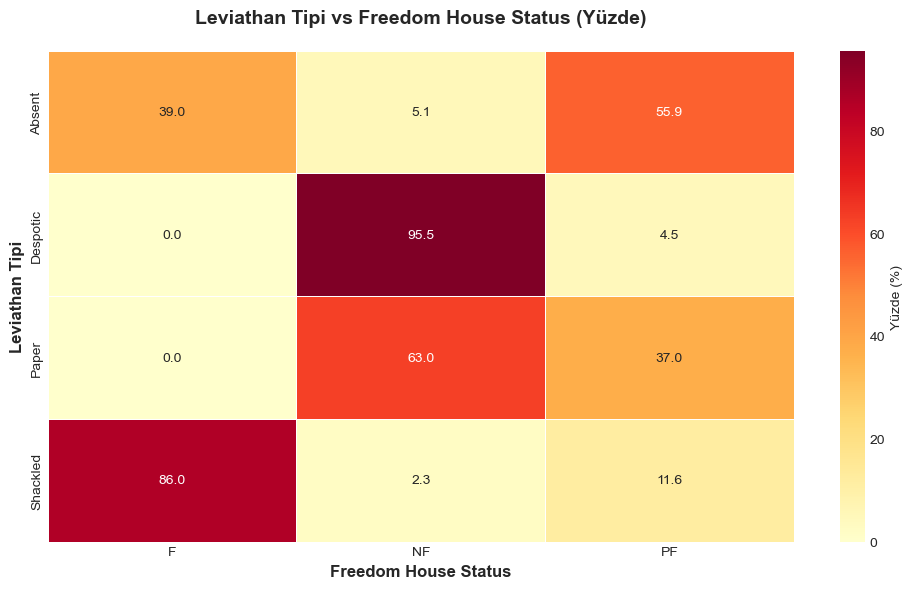


✓ Karşılaştırma ısı haritası oluşturuldu


In [ ]:
# Isı haritası
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(crosstab_pct, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Yüzde (%)'}, linewidths=0.5,
            ax=ax)
ax.set_title('Leviathan Tipi vs Freedom House Status (Yüzde)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Freedom House Status', fontsize=12, fontweight='bold')
ax.set_ylabel('Leviathan Tipi', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Karşılaştırma ısı haritası oluşturuldu")


## 9. Veri Eksportu

Hesaplanan faktör skorlarını ve kümeleri CSV ve JSON formatlarında kaydediyoruz.


In [ ]:
# Tüm yıllar için CSV eksportu
export_cols = ['countryname', 'year', 'StatePower', 'SocietyPower', 'Cluster', 'LeviathanType']
export_df = merged_std[export_cols].copy()

# Eksik değerleri temizle
export_df = export_df.dropna(subset=['StatePower', 'SocietyPower'])

# CSV olarak kaydet
output_csv = '../Datasets/processed2/factor_scores_1996_2022.csv'
export_df.to_csv(output_csv, index=False)

print(f"✓ Tüm yıllar CSV'ye kaydedildi: {output_csv}")
print(f"  Toplam {len(export_df)} gözlem ({export_df['countryname'].nunique()} ülke)")
print(f"  Yıl aralığı: {export_df['year'].min()}-{export_df['year'].max()}")


✓ Tüm yıllar CSV'ye kaydedildi: ../Datasets/processed2/factor_scores_1996_2022.csv
  Toplam 4160 gözlem (173 ülke)
  Yıl aralığı: 1996-2023


In [ ]:
# 2022 verisini JSON formatında kaydet (web paneli için)
data_2022_export = data_2022[['countryname', 'StatePower', 'SocietyPower', 
                               'LeviathanType', 'Cluster']].copy()
data_2022_export = data_2022_export.dropna()

# JSON yapısını oluştur
json_output = {
    'year': 2022,
    'countries': []
}

for _, row in data_2022_export.iterrows():
    json_output['countries'].append({
        'name': row['countryname'],
        'statePower': round(float(row['StatePower']), 3),
        'societyPower': round(float(row['SocietyPower']), 3),
        'leviathanType': row['LeviathanType'],
        'cluster': int(row['Cluster'])
    })

# JSON olarak kaydet
output_json = '../Datasets/processed2/dar_koridor_latest_2022.json'
with open(output_json, 'w', encoding='utf-8') as f:
    json.dump(json_output, f, ensure_ascii=False, indent=2)

print(f"\n✓ 2022 verisi JSON'a kaydedildi: {output_json}")
print(f"  {len(json_output['countries'])} ülke")

# İlk 3 ülkeyi göster
print(f"\n✓ JSON yapısı (ilk 3 ülke):")
for country in json_output['countries'][:3]:
    print(f"  {country['name']}: SP={country['statePower']}, SoP={country['societyPower']}, Type={country['leviathanType']}")



✓ 2022 verisi JSON'a kaydedildi: ../Datasets/processed2/dar_koridor_latest_2022.json
  166 ülke

✓ JSON yapısı (ilk 3 ülke):
  Afghanistan: SP=-0.97, SoP=-1.92, Type=Despotic
  Albania: SP=-0.18, SoP=0.473, Type=Absent
  Algeria: SP=-0.176, SoP=-1.359, Type=Despotic


## 10. Özet ve Bulgular

Analiz tamamlandı. Aşağıda temel bulguları özetliyoruz.


In [ ]:
print("="*70)
print("ANALİZ ÖZET RAPORU")
print("="*70)

print(f"\n📊 VERİ KAPSAMI:")
print(f"  • Yıl aralığı: {export_df['year'].min()}-{export_df['year'].max()}")
print(f"  • Toplam gözlem: {len(export_df)}")
print(f"  • Ülke sayısı: {export_df['countryname'].nunique()}")

print(f"\n🔍 FAKTÖR ANALİZİ:")
print(f"  • 2 faktör çıkarıldı (Devlet Gücü, Toplum Gücü)")
print(f"  • Toplam varyans açıklama: {variance_df.loc['Cumulative Var', 'Factor2']:.1%}")
print(f"  • Rotasyon: Varimax")

print(f"\n🎯 KÜMELEME (K=4):")
for lev_type in export_df['LeviathanType'].unique():
    if pd.notna(lev_type):
        count = (export_df['LeviathanType'] == lev_type).sum()
        pct = count / len(export_df) * 100
        print(f"  • {lev_type}: {count} gözlem ({pct:.1f}%)")

print(f"\n📈 1996 vs 2022 KARŞILAŞTIRMASI:")
print(f"  • 1996: {len(data_1996)} ülke")
print(f"  • 2022: {len(data_2022)} ülke")

print(f"\n✅ ÇIKTILAR:")
print(f"  • CSV: {output_csv}")
print(f"  • JSON: {output_json}")

print("\n" + "="*70)
print("Analiz başarıyla tamamlandı!")
print("="*70)


ANALİZ ÖZET RAPORU

📊 VERİ KAPSAMI:
  • Yıl aralığı: 1996-2023
  • Toplam gözlem: 4160
  • Ülke sayısı: 173

🔍 FAKTÖR ANALİZİ:
  • 2 faktör çıkarıldı (Devlet Gücü, Toplum Gücü)
  • Toplam varyans açıklama: 84.8%
  • Rotasyon: Varimax

🎯 KÜMELEME (K=4):
  • Paper: 825 gözlem (19.8%)
  • Despotic: 728 gözlem (17.5%)
  • Absent: 1491 gözlem (35.8%)
  • Shackled: 1116 gözlem (26.8%)

📈 1996 vs 2022 KARŞILAŞTIRMASI:
  • 1996: 158 ülke
  • 2022: 166 ülke

✅ ÇIKTILAR:
  • CSV: ../Datasets/processed2/factor_scores_1996_2022.csv
  • JSON: ../Datasets/processed2/dar_koridor_latest_2022.json

Analiz başarıyla tamamlandı!
